# Quay Wall Failure and Maintenance Analysis

**Author:** Enrico Calleris
**Institution:** Gemeente Amsterdam  
**Date:** Feb 24 - Oct 24

This notebook presents a comprehensive analysis of quay wall failure data and maintenance actions, based on historical and ongoing projects undertaken by the Municipality of Amsterdam (Gemeente Amsterdam). The work builds upon the foundational research and contributions by Jesse van Remmerden and Maurice Kenter.

## Objective

The primary objective of this notebook is to evaluate the performance, failure patterns, and maintenance actions of various quay walls in the city of Amsterdam. This project forms part of a broader initiative to maintain and improve critical infrastructure, ensuring its safety and longevity. By processing and analyzing data on quay wall maintenance and failures, we aim to derive insights that can inform future maintenance strategies.

## Contributions

This project is the result of collaboration between Maurice Kenter, Enrico Calleris, and experts in the field of AI, ICT and civil engineering. Their efforts have been instrumental in refining the methodologies and applying state-of-the-art techniques to assess the reliability of quay wall infrastructure. The current work enhances and builds upon the groundwork laid by Jesse van Remmerden, adapting the models and analysis to the specific use cases relevant to the Municipality of Amsterdam.

## Data and Confidentiality

The data utilized in this notebook, along with the results and analyses presented, are confidential and proprietary to Gemeente Amsterdam and Maurice Kenter. All rights, including those of publication and distribution, belong to Gemeente Amsterdam and Maurice Kenter. Any unauthorized access, reproduction, or distribution of this content is strictly prohibited.


## 0. Load Modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

## 1. Load the Data

In [88]:
# Read the ARK Data
ARK_data = pd.read_csv("../../MODCMAC/data/cleaned_data_ARK_150324.xls")

# Read the safety_data csv which contains the maintenance
maintenance = pd.read_csv("../../MODCMAC/data/safety_data.csv", sep=";", names=['Quaywall nr','leeftijd'])

# Read the Scoring Table file
scoring = pd.read_csv('../../MODCMAC/results/PRG0401-AML/MO_DCMAC_scoring.csv')

In [89]:
# Select only the letter code of each quay wall
ARK_data['Quaywall nr'] = ARK_data['Quaywall nr'].str.split('-').str[0]

# Convert the date column to the right datetime format
maintenance['leeftijd'] = pd.to_datetime(maintenance['leeftijd'], format="%d-%m-%Y")

## 2. Calculate Lambda Value for Weibull

85th Percentile:  126.9
Estimated lambda: 98.22537657292935


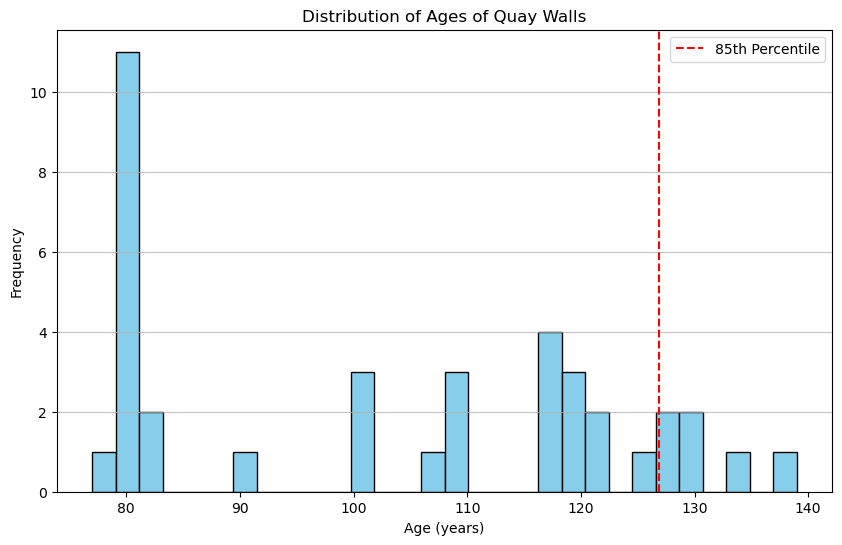

In [90]:
# Perform lambda calculation assuming kappa = 2.5
kappa = 2.5  # Shape parameter for Weibull distribution

# Gather all quay wall codes
df_qw = set(ARK_data['Quaywall nr'])
main_qw = set(maintenance['Quaywall nr'])
final_qw = df_qw.intersection(main_qw)

# Calculate the number of years passed until today
today = datetime.today()
maintenance['leeftijd'] = maintenance['leeftijd'].apply(lambda x: (today - x).days / 365.25).astype(int)
maintenance_age = maintenance['leeftijd']

# Set 'Quaywall nr' as the index for easier lookup
ARK_data.set_index('Quaywall nr', inplace=True)
maintenance.set_index('Quaywall nr', inplace=True)

# Subtract the years of maintenance from the age in the main dataframe
for val in final_qw:
        ARK_data.at[val, 'leeftijd'] -= maintenance.at[val, 'leeftijd']

# Create a new Series with all the ages
final_ages = ARK_data['leeftijd']

# Calculate the 85th percentile from the final age data
p85 = np.percentile(final_ages, 85)

print("85th Percentile: ", p85)

# Calculate the scale parameter lambda using the 85th percentile and assumed kappa
lambda_ = p85 / ((-np.log(1 - 0.85))**(1/kappa))

# Output the estimated lambda
print(f"Estimated lambda: {lambda_}")

# Plot the age data
plt.figure(figsize=(10, 6))
plt.hist(final_ages, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Ages of Quay Walls')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Plot the vertical red line at the 85th percentile
plt.axvline(x=p85, color='red', linestyle='--', label='85th Percentile')

plt.legend()  # Show legend

plt.show()

## 3. Degradation Matrices

In [91]:
# Different degradation matrices for different value of kappa
# Lambda is fixed at lambda_ (from previous analysis)

# P_start (remains fixed)
P_start = np.zeros((3, 5, 5))
P_start[0] = np.array([
        [0.983, 0.0089, 0.0055, 0.0025, 0.0001],
        [0, 0.9836, 0.0084, 0.0054, 0.0026],
        [0, 0, 0.9862, 0.0084, 0.0054],
        [0, 0, 0, 0.9917, 0.0083],
        [0, 0, 0, 0, 1]
    ])
P_start[1] = np.array([
        [0.9748, 0.013, 0.0081, 0.004, 0.0001],
        [0., 0.9754, 0.0124, 0.0081, 0.0041],
        [0., 0., 0.9793, 0.0125, 0.0082],
        [0., 0., 0., 0.9876, 0.0124],
        [0., 0., 0., 0., 1.]
    ])
P_start[2] = np.array([
        [0.9848, 0.008, 0.0049, 0.0022, 0.0001],
        [0., 0.9854, 0.0074, 0.0048, 0.0024],
        [0., 0., 0.9876, 0.0075, 0.0049],
        [0., 0., 0., 0.9926, 0.0074],
        [0., 0., 0., 0., 1.]
    ])
    
# P_end for kappa = 1.5
P_end_1_5 = np.zeros((3, 5, 5))
P_end_1_5[0] = np.array([
        [0.664, 0.328, 0.005, 0.002, 0.   ],
        [0.,    0.664, 0.328, 0.005, 0.003],
        [0.,    0.,    0.667, 0.328, 0.005],
        [0.,    0.,    0.,    0.672, 0.328],
        [0.,    0.,    0.,    0.,    1.   ]
])
P_end_1_5[1] = np.array([
        [0.657, 0.331, 0.008, 0.004, 0.   ],
        [0.,    0.657, 0.33,  0.008, 0.004],
        [0.,    0.,    0.661, 0.331, 0.008],
        [0.,    0.,    0.,    0.67,  0.33 ],
        [0.,    0.,    0.,    0.,    1.   ]
])
P_end_1_5[2] = np.array([
        [0.665, 0.327, 0.005, 0.002, 0.   ],
        [0.,    0.666, 0.327, 0.005, 0.002],
        [0.,    0.,    0.668, 0.327, 0.005],
        [0.,    0.,    0.,    0.673, 0.327],
        [0.,    0.,    0.,    0.,    1.   ]
])

# P_end for kappa = 2
P_end_2 = np.zeros((3, 5, 5))
P_end_2[0] = np.array([
        [0.738, 0.254, 0.005, 0.002, 0.   ],
        [0.   , 0.739, 0.253, 0.005, 0.003],
        [0.   , 0.   , 0.741, 0.253, 0.005],
        [0.   , 0.   , 0.   , 0.747, 0.253],
        [0.   , 0.   , 0.   , 0.   , 1.   ]
])
P_end_2[1] = np.array([
        [0.731, 0.257, 0.008, 0.004, 0.   ],
        [0.   , 0.731, 0.256, 0.008, 0.004],
        [0.   , 0.   , 0.735, 0.256, 0.008],
        [0.   , 0.   , 0.   , 0.744, 0.256],
        [0.   , 0.   , 0.   , 0.   , 1.   ]
])
P_end_2[2] =  np.array([
        [0.74 , 0.253, 0.005, 0.002, 0.   ],
        [0.   , 0.74 , 0.253, 0.005, 0.002],
        [0.   , 0.   , 0.742, 0.253, 0.005],
        [0.   , 0.   , 0.   , 0.747, 0.253],
        [0.   , 0.   , 0.   , 0.   , 1.   ]
])

# P_end for kappa (baseline) = 2.5
P_end_2_5 = np.zeros((3, 5, 5))
P_end_2_5[0] = np.array([
        [0.798, 0.194, 0.005, 0.002, 0.   ],
        [0.   , 0.798, 0.194, 0.005, 0.003],
        [0.   , 0.   , 0.801, 0.194, 0.005],
        [0.   , 0.   , 0.   , 0.806, 0.194],
        [0.   , 0.   , 0.   , 0.   , 1.   ]
])
P_end_2_5[1] = np.array([
        [0.79 , 0.198, 0.008, 0.004, 0.   ],
        [0.   , 0.791, 0.197, 0.008, 0.004],
        [0.   , 0.   , 0.795, 0.197, 0.008],
        [0.   , 0.   , 0.   , 0.803, 0.197],
        [0.   , 0.   , 0.   , 0.   , 1.   ]
])
P_end_2_5[2] =  np.array([
        [0.799, 0.194, 0.005, 0.002, 0.   ],
        [0.   , 0.8  , 0.193, 0.005, 0.002],
        [0.   , 0.   , 0.802, 0.193, 0.005],
        [0.   , 0.   , 0.   , 0.807, 0.193],
        [0.   , 0.   , 0.   , 0.   , 1.   ]
])

# P_end for kappa = 3
P_end_3 = np.zeros((3, 5, 5))
P_end_3[0] = np.array([
        [0.844, 0.148, 0.005, 0.002, 0.   ],
        [0.   , 0.845, 0.147, 0.005, 0.003],
        [0.   , 0.   , 0.847, 0.147, 0.005],
        [0.   , 0.   , 0.   , 0.853, 0.147],
        [0.   , 0.   , 0.   , 0.   , 1.   ]
])
P_end_3[1] = np.array([
        [0.836, 0.151, 0.008, 0.004, 0.   ],
        [0.   , 0.837, 0.151, 0.008, 0.004],
        [0.   , 0.   , 0.841, 0.151, 0.008],
        [0.   , 0.   , 0.   , 0.849, 0.151],
        [0.   , 0.   , 0.   , 0.   , 1.   ]
])
P_end_3[2] =  np.array([
        [0.846, 0.147, 0.005, 0.002, 0.   ],
        [0.   , 0.846, 0.147, 0.005, 0.002],
        [0.   , 0.   , 0.848, 0.147, 0.005],
        [0.   , 0.   , 0.   , 0.853, 0.147],
        [0.   , 0.   , 0.   , 0.   , 1.   ]
])

# Stack the matrices together
P_end = np.array([P_end_1_5, P_end_2, P_end_2_5, P_end_3])

# Calculate successive pairwise differences
differences = np.diff(P_end, axis=0)

# Calculate the average of the differences
average_difference = np.mean(differences, axis=0)

print(average_difference.round(5))

[[[ 0.06    -0.06     0.       0.       0.     ]
  [ 0.       0.06033 -0.06033  0.       0.     ]
  [ 0.       0.       0.06    -0.06033  0.     ]
  [ 0.       0.       0.       0.06033 -0.06033]
  [ 0.       0.       0.       0.       0.     ]]

 [[ 0.05967 -0.06     0.       0.       0.     ]
  [ 0.       0.06    -0.05967  0.       0.     ]
  [ 0.       0.       0.06    -0.06     0.     ]
  [ 0.       0.       0.       0.05967 -0.05967]
  [ 0.       0.       0.       0.       0.     ]]

 [[ 0.06033 -0.06     0.       0.       0.     ]
  [ 0.       0.06    -0.06     0.       0.     ]
  [ 0.       0.       0.06    -0.06     0.     ]
  [ 0.       0.       0.       0.06    -0.06   ]
  [ 0.       0.       0.       0.       0.     ]]]


## 4. Failure Analysis for Single Quay Wall

### 4.1. Define Helper Functions

In [92]:
def extract_component_states(df):
    """
    Extracts component states and action columns from the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing the scoring table with component states and actions.

    Returns:
        tuple: 
            - component_states (dict): A dictionary mapping each component number to its corresponding state columns.
            - action_columns (dict): A dictionary mapping each component number to its action column.
    """
    component_states = {}
    action_columns = {}

    # Iterate over all columns to find state and action columns for each component
    for col in df.columns:
        if col.startswith("state_comp_"):  # State columns follow the format 'state_comp_<component>_<state>'
            comp_num, state_num = col.split("_")[2], col.split("_")[4]
            if comp_num not in component_states:
                component_states[comp_num] = []
            component_states[comp_num].append((col, state_num))  # Map component to its corresponding states
        elif col.startswith("action_comp_"):  # Action columns follow the format 'action_comp_<component>'
            comp_num = col.split("_")[2]
            action_columns[comp_num] = col  # Map component to its action column

    return component_states, action_columns


def create_timestep_df(df, component_states, action_columns, action_map):
    """
    Creates a DataFrame for each timestep, indicating the state and action for each component.

    Args:
        df (pd.DataFrame): DataFrame containing the scoring table.
        component_states (dict): Mapping of component numbers to their states.
        action_columns (dict): Mapping of component numbers to their action columns.
        action_map (dict): Mapping of action codes to their action descriptions.

    Returns:
        pd.DataFrame: A new DataFrame containing states and actions for each component at each timestep.
    """
    output_dfs = []

    # Iterate through each row (timestep) to build the DataFrame for each timestep
    for index, row in df.iterrows():
        timestep_states = {}
        for comp_num, states_list in component_states.items():
            comp_state = None
            comp_action = None

            # Determine the component state based on the values in the state columns
            for state_col, state_num in states_list:
                if row[state_col] == 1:  # If state is active (value == 1), assign the state
                    comp_state = state_num
                    comp_action = action_map[row[action_columns[comp_num]]]  # Assign the corresponding action
                    break

            # Store the component state and action for the current timestep
            timestep_states[f"Component {comp_num} State"] = comp_state
            timestep_states[f"Component {comp_num} Action"] = comp_action

        # Append the DataFrame for the current timestep
        output_dfs.append(pd.DataFrame(timestep_states, index=[0]))

    return pd.concat(output_dfs, ignore_index=True)  # Concatenate all timestep DataFrames


def count_failures_per_component(output_df):
    """
    Counts the number of failures per component and logs failures within the first 7 timesteps.

    Args:
        output_df (pd.DataFrame): DataFrame containing the states and actions for each component.

    Returns:
        pd.DataFrame: A DataFrame summarizing failure statistics for each component.
    """
    failures_per_component = {}

    # Iterate through columns related to component states and calculate failure statistics
    for col in output_df.columns:
        if col.endswith("State"):
            comp_num = col.split(" ")[1]  # Extract component number
            failure_count = output_df[col].eq('4').sum()  # Count failures where state is '4'
            avg_failures_per_timestep = failure_count / len(output_df)  # Calculate average failures per timestep
            first_7_failures_count = output_df.iloc[:7][col].eq('4').sum()  # Count failures within the first 7 timesteps

            # Store failure statistics for each component
            failures_per_component[comp_num] = {
                'Failure Count': failure_count,
                'Average Failures per Timestep': avg_failures_per_timestep,
                'Failures within First 7 Timesteps': first_7_failures_count
            }

    # Convert the failure statistics dictionary to a DataFrame
    failures_df = pd.DataFrame.from_dict(failures_per_component, orient='index')
    failures_df['Component Number'] = failures_df.index
    failures_df = failures_df[['Component Number', 'Failure Count', 'Average Failures per Timestep', 'Failures within First 7 Timesteps']]
    
    return failures_df


def calculate_cumulative_actions(output_df):
    """
    Calculates the cumulative number of actions (repair, replace) for each component across timesteps.

    Args:
        output_df (pd.DataFrame): DataFrame containing the states and actions for each component at each timestep.

    Returns:
        pd.DataFrame: A DataFrame containing the cumulative count of actions for each component-action pair.
    """
    cumulative_actions = {}
    comp_action_counts = {(comp_num, action): 0 for comp_num in range(13) for action in ['Replace', 'Repair']}  # Initialize counts

    prev_counts = comp_action_counts.copy()  # Keep track of previous counts for change detection

    # Iterate through each timestep starting from the second one
    for index, row in output_df.iloc[1:].iterrows():
        for comp_num in range(13):
            action = row[f'Component {comp_num} Action']
            if action in ['Repair', 'Replace']:  # Count only 'Repair' and 'Replace' actions
                comp_action_counts[(comp_num, action)] += 1

        count_changes = {k: v - prev_counts.get(k, 0) for k, v in comp_action_counts.items()}  # Calculate the change in actions
        prev_counts = comp_action_counts.copy()
        cumulative_actions[index] = count_changes  # Store cumulative actions for the current timestep

    cumulative_actions_df = pd.DataFrame(cumulative_actions).fillna(0).astype(int)
    
    return cumulative_actions_df


def reformat_cumulative_actions(cumulative_actions_df):
    """
    Reformats the cumulative actions DataFrame to make it more readable, adding aggregated columns for certain years.

    Args:
        cumulative_actions_df (pd.DataFrame): The DataFrame containing cumulative actions for each component-action pair.

    Returns:
        pd.DataFrame: A reformatted DataFrame with specified column names, including sums for specific year ranges.
    """
    final_dfs = []

    # Iterate through each component-action pair and reformat the data
    for (comp_num, action), counts in cumulative_actions_df.iterrows():
        data = {'Component Number': [comp_num], 'Action Type': [action]}
        data.update({f'Y{index}': [count] for index, count in counts.items()})  # Rename columns to 'Y<number>' for years
        df = pd.DataFrame(data)
        final_dfs.append(df)

    final_df = pd.concat(final_dfs, ignore_index=True).fillna(0)

    # Calculate the cumulative actions for specific year ranges
    final_df['Y15'] = final_df.loc[:, 'Y11':'Y15'].sum(axis=1)
    final_df['Y20'] = final_df.loc[:, 'Y16':'Y20'].sum(axis=1)
    final_df['Y30'] = final_df.loc[:, 'Y21':'Y30'].sum(axis=1)
    final_df['Y40'] = final_df.loc[:, 'Y31':'Y40'].sum(axis=1)
    final_df['Y50'] = final_df.loc[:, 'Y41':'Y50'].sum(axis=1)

    # Keep only relevant columns
    final_df = final_df[['Component Number', 'Action Type', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Y10', 'Y15', 'Y20', 'Y30', 'Y40', 'Y50']]

    return final_df


def plot_failure_counts(failures_df):
    """
    Plots a histogram showing the failure counts for each component.

    Args:
        failures_df (pd.DataFrame): DataFrame containing failure statistics for each component.
    """
    plt.figure(figsize=(10, 5))
    plt.bar(failures_df['Component Number'], failures_df['Failure Count'], color='skyblue')  # Bar plot for failure counts
    plt.xlabel('Component Number')
    plt.ylabel('Failure Count')
    plt.title('Failure Counts per Component')
    plt.xticks(failures_df['Component Number'])  # Ensure proper labeling of component numbers
    plt.gca().set_facecolor('white')
    plt.show()


def plot_avg_failures_per_timestep(failures_df):
    """
    Plots a histogram showing the average failures per year for each component.

    Args:
        failures_df (pd.DataFrame): DataFrame containing failure statistics for each component.
    """
    plt.figure(figsize=(10, 5))
    plt.bar(failures_df['Component Number'], failures_df['Average Failures per Timestep'], color='lightgreen')
    plt.xlabel('Component Number')
    plt.ylabel('Average Failures per Year')
    plt.title('Average Failures per Year')
    plt.xticks(failures_df['Component Number'])
    plt.gca().set_facecolor('white')
    plt.show()


def plot_total_failures_comparison(total_failures_7_years, total_avg_failures_modcmac):
    """
    Plots a comparison of total failures over 7 years for the Reactive and MO-DCMAC models.

    Args:
        total_failures_7_years (int): Total failures over 7 years for the reactive model.
        total_avg_failures_modcmac (float): Average failures per year for the MO-DCMAC model.
    """
    plt.figure(figsize=(10, 5))
    bars = plt.bar(['Reactive Model', 'MO-DCMAC Model'], [total_failures_7_years, total_avg_failures_modcmac],
                   color=['skyblue', 'lightgreen'])
    plt.xlabel('Model')
    plt.ylabel('Total Failures over 7 years')
    plt.title('Comparison of Total Failures for Reactive and MO-DCMAC Models over 7 years')

    # Annotate the bar plot with the failure counts
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, '%d' % int(height), ha='center', va='bottom')

    plt.show()


def plot_avg_failures_comparison(total_avg_failures_reactive, total_avg_failures_modcmac):
    """
    Plots a comparison of average failures per year for the Reactive and MO-DCMAC models.

    Args:
        total_avg_failures_reactive (float): Average failures per year for the reactive model.
        total_avg_failures_modcmac (float): Average failures per year for the MO-DCMAC model.
    """
    plt.figure(figsize=(10, 5))
    bars = plt.bar(['Reactive Model', 'MO-DCMAC Model'], [total_avg_failures_reactive, total_avg_failures_modcmac],
                   color=['skyblue', 'lightgreen'])
    plt.xlabel('Model')
    plt.ylabel('Average Failures per Year')
    plt.title('Comparison of Average Failures per Year for Reactive and MO-DCMAC Models')

    # Annotate the bar plot with the failure averages
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, '%.3f' % height, ha='center', va='bottom')

    plt.show()


def plot_failures_by_component_type(failures_df):
    """Plots total failures over the entire timeframe for MO-DCMAC model by component type.

    Args:
        failures_df (pd.DataFrame): DataFrame containing failure statistics for each component.
    """
    component_types = {
        'Poles': range(9),
        'Kesps': range(9, 12),
        'Floor': [12]
    }

    failures_per_component_type = {component_type: 0 for component_type in component_types}

    # Aggregate failures by component type (Poles, Kesps, Floor)
    for index, row in failures_df.iterrows():
        component_number = int(index)
        component_failures = row['Failure Count']
        for component_type, component_nums in component_types.items():
            if component_number in component_nums:
                failures_per_component_type[component_type] += component_failures
                break

    # Plot the aggregated failures for each component type
    plt.figure(figsize=(10, 5))
    bars = plt.bar(failures_per_component_type.keys(), failures_per_component_type.values(),
                   color=['skyblue', 'lightgreen', 'salmon'])
    plt.xlabel('Component Type')
    plt.ylabel('Total Failures')
    plt.title('Total Failures for MO-DCMAC Model by Component Type')

    # Add total number of failures on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom')

    plt.show()


def plot_cumulative_actions(final_df):
    """
    Plots cumulative repair and replace actions for each component.

    Args:
        final_df (pd.DataFrame): DataFrame containing cumulative actions for each component-action pair.
    """
    data = final_df.drop(columns=['Component Number', 'Action Type']).values
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot for Repair actions
    repair_data = final_df[final_df['Action Type'] == 'Repair'].drop(columns=['Component Number', 'Action Type']).values
    axs[0].pcolormesh(repair_data, cmap='RdYlGn_r', edgecolors='k', linewidth=2, vmin=repair_data.min(), vmax=repair_data.max())

    # Annotate the repair plot with actual data values
    for i in range(repair_data.shape[0]):
        for j in range(repair_data.shape[1]):
            if repair_data[i, j] != 0:
                axs[0].text(j + 0.5, i + 0.5, repair_data[i, j], color='black', ha='center', va='center')

    # Sum of row totals (repair actions per component)
    repair_row_totals = repair_data.sum(axis=1)
    for i, total in enumerate(repair_row_totals):
        axs[0].text(repair_data.shape[1] + 0.5, i + 0.5, total, color='black', ha='center', va='center')

    axs[0].set_title('Repair Action')
    axs[0].set_ylabel('Component Number')
    axs[0].set_yticks(np.arange(repair_data.shape[0]) + 0.5)
    axs[0].set_yticklabels(final_df[final_df['Action Type'] == 'Repair']['Component Number'], fontsize=8)
    axs[0].invert_yaxis()

    # Plot for Replace actions
    replace_data = final_df[final_df['Action Type'] == 'Replace'].drop(columns=['Component Number', 'Action Type']).values
    axs[1].pcolormesh(replace_data, cmap='RdYlGn_r', edgecolors='k', linewidth=2, vmin=replace_data.min(), vmax=replace_data.max())

    # Annotate the replace plot with actual data values
    for i in range(replace_data.shape[0]):
        for j in range(replace_data.shape[1]):
            if replace_data[i, j] != 0:
                axs[1].text(j + 0.5, i + 0.5, replace_data[i, j], color='black', ha='center', va='center')

    # Sum of row totals (replace actions per component)
    replace_row_totals = replace_data.sum(axis=1)
    for i, total in enumerate(replace_row_totals):
        axs[1].text(replace_data.shape[1] + 0.5, i + 0.5, total, color='black', ha='center', va='center')

    axs[1].set_title('Replace Action')
    axs[1].set_ylabel('Component Number')
    axs[1].set_yticks(np.arange(replace_data.shape[0]) + 0.5)
    axs[1].set_yticklabels(final_df[final_df['Action Type'] == 'Replace']['Component Number'], fontsize=8)
    axs[1].invert_yaxis()

    # Configure x-axis for both plots (timesteps)
    for ax in axs:
        ax.set_xticks(np.arange(len(final_df.columns[2:])) + 0.5)
        ax.set_xticklabels(final_df.columns[2:], rotation=45, ha='right')
        ax.set_xlabel('Timestep')

    plt.tight_layout()
    plt.savefig('component_actions.png', bbox_inches='tight', pad_inches=0, facecolor='white')
    plt.show()

### 4.2. Retrieve Components State and Action at each timestep

In [93]:
# Define Action Map
action_map = {0: 'Nothing', 1: 'Repair', 2: 'Replace'}

# Extract component states
components, actions = extract_component_states(scoring)

# Create Timestep DataFrames
timestep_scoring = create_timestep_df(scoring, components, actions, action_map)

# Show the resulting DataFrame for inspection
timestep_scoring

,Component 0 State,Component 0 Action,Component 1 State,Component 1 Action,Component 2 State,Component 2 Action,Component 3 State,Component 3 Action,Component 4 State,Component 4 Action,...,Component 8 State,Component 8 Action,Component 9 State,Component 9 Action,Component 10 State,Component 10 Action,Component 11 State,Component 11 Action,Component 12 State,Component 12 Action
0,3,Nothing,3,Nothing,2,Nothing,3,Nothing,2,Nothing,...,3,Nothing,2,Nothing,3,Nothing,2,Nothing,2,Nothing
1,2,Repair,2,Repair,1,Repair,2,Repair,1,Repair,...,2,Repair,1,Repair,0,Replace,1,Repair,1,Repair
2,1,Repair,1,Repair,0,Repair,1,Repair,1,Nothing,...,1,Repair,0,Repair,0,Repair,0,Repair,1,Nothing
3,1,Nothing,0,Repair,0,Nothing,1,Nothing,1,Nothing,...,0,Repair,0,Nothing,0,Nothing,0,Nothing,0,Repair
4,1,Nothing,0,Nothing,0,Nothing,0,Repair,1,Nothing,...,0,Nothing,0,Nothing,0,Nothing,0,Nothing,0,Nothing
5,0,Repair,0,Nothing,0,Nothing,0,Nothing,1,Nothing,...,0,Nothing,0,Nothing,0,Nothing,0,Nothing,0,Nothing
6,0,Nothing,0,Nothing,0,Nothing,0,Nothing,1,Nothing,...,0,Nothing,0,Nothing,0,Nothing,0,Nothing,0,Nothing
7,0,Nothing,0,Nothing,0,Nothing,0,Nothing,1,Nothing,...,0,Nothing,2,Nothing,0,Nothing,0,Nothing,0,Nothing
8,0,Nothing,0,Nothing,0,Nothing,0,Nothing,1,Nothing,...,0,Nothing,1,Repair,0,Nothing,2,Nothing,0,Nothing
9,0,Nothing,0,Nothing,0,Nothing,0,Nothing,1,Nothing,...,0,Nothing,0,Repair,0,Repair,1,Repair,0,Nothing


### 4.3. Calculate Failures for each Component

In [94]:
# Calculate Failures per Component
failures = count_failures_per_component(timestep_scoring)

# Show the resulting DataFrame for inspection
failures

,Component Number,Failure Count,Average Failures per Timestep,Failures within First 7 Timesteps
0,0,0,0.0,0
1,1,0,0.0,0
2,2,0,0.0,0
3,3,0,0.0,0
4,4,0,0.0,0
5,5,0,0.0,0
6,6,0,0.0,0
7,7,0,0.0,0
8,8,0,0.0,0
9,9,0,0.0,0


### 4.4. Calculate Cumulative Actions for each Component

In [95]:
# Calculate Cumulative Actions
cumulative_actions = calculate_cumulative_actions(timestep_scoring)

# Reformat Cumulative Actions
cumulative_actions_reformatted = reformat_cumulative_actions(cumulative_actions)

# Show the resulting DataFrame for inspection
cumulative_actions_reformatted

,Component Number,Action Type,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10,Y15,Y20,Y30,Y40,Y50
0,0,Replace,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,Repair,1,1,0,0,1,0,0,0,0,0,2,0,0,1,0
2,1,Replace,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,Repair,1,1,1,0,0,0,0,0,0,0,0,0,0,0,2
4,2,Replace,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2,Repair,1,1,0,0,0,0,0,0,0,0,0,0,0,0,2
6,3,Replace,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,3,Repair,1,1,0,1,0,0,0,0,0,0,1,0,0,1,0
8,4,Replace,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,4,Repair,1,0,0,0,0,0,0,0,0,0,1,2,1,0,0


### 4.5. Plots

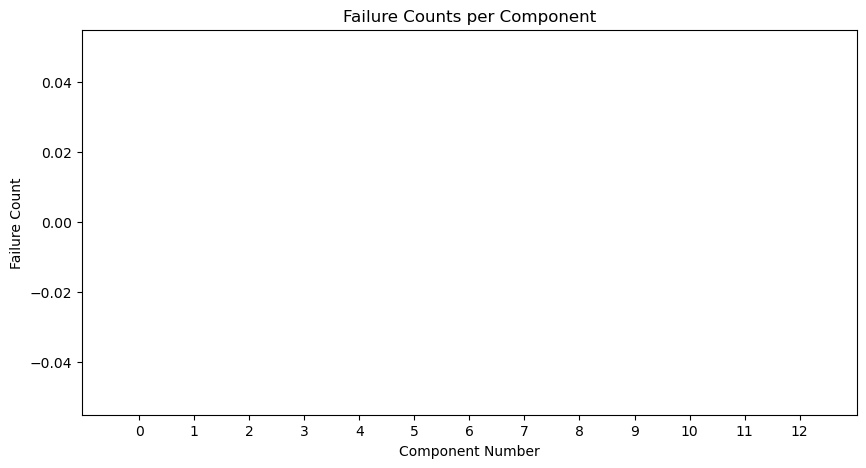

In [96]:
plot_failure_counts(failures)

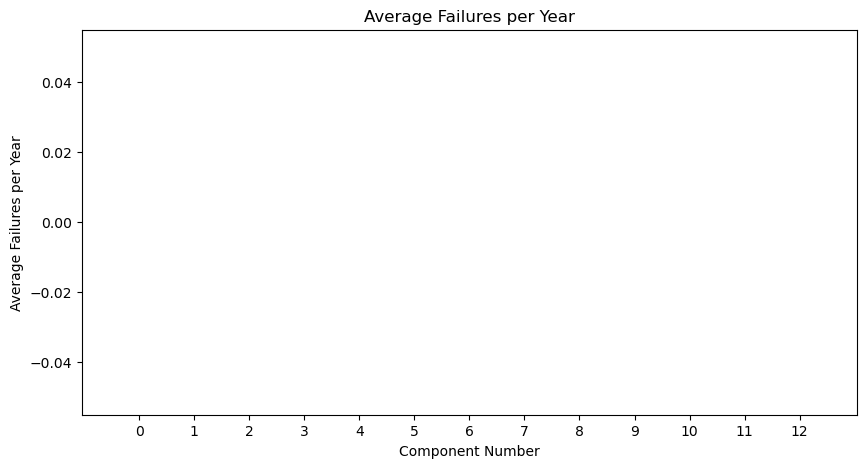

In [97]:
plot_avg_failures_per_timestep(failures)

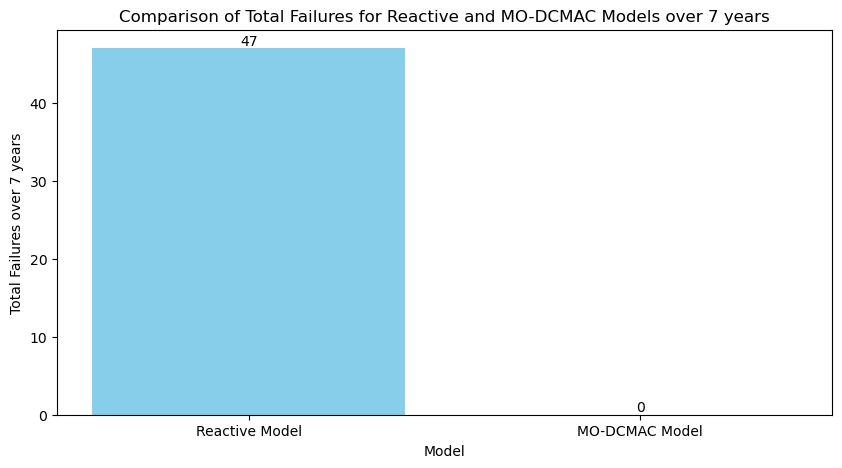

In [98]:
# Here, you can customize the numbers with the ones that reflect you analysis
plot_total_failures_comparison(47, failures['Average Failures per Timestep'].mean())

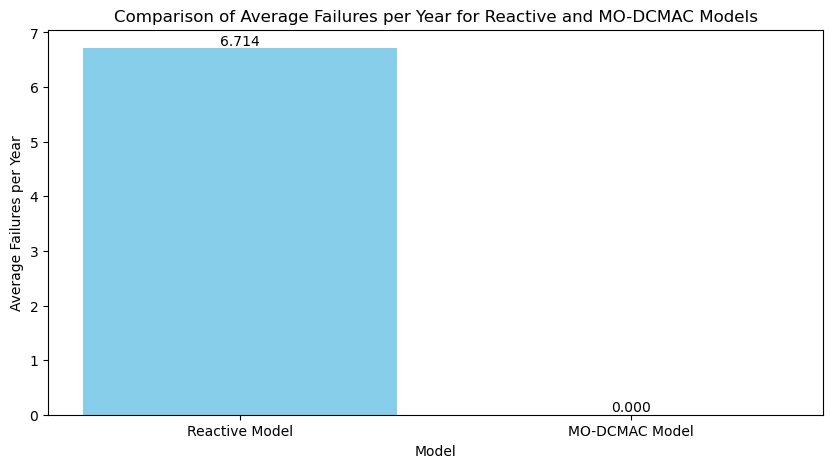

In [99]:
# Here, you can customize the numbers with the ones that reflect you analysis
plot_avg_failures_comparison(47 / 7, failures['Average Failures per Timestep'].mean())

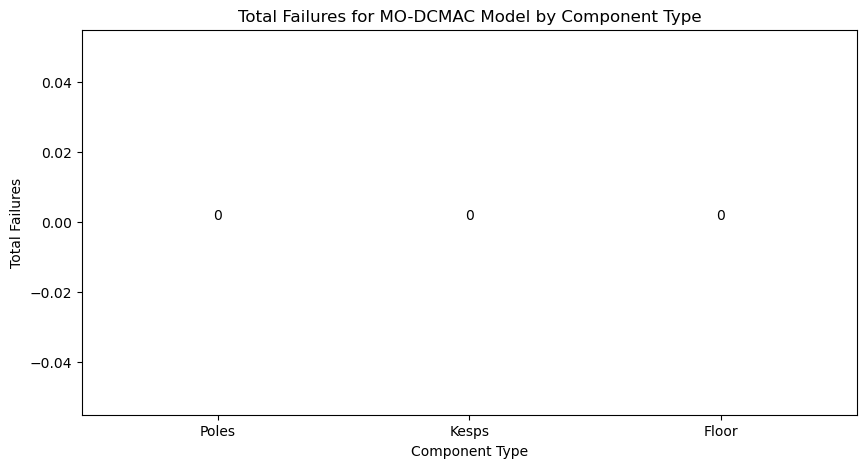

In [100]:
plot_failures_by_component_type(failures)

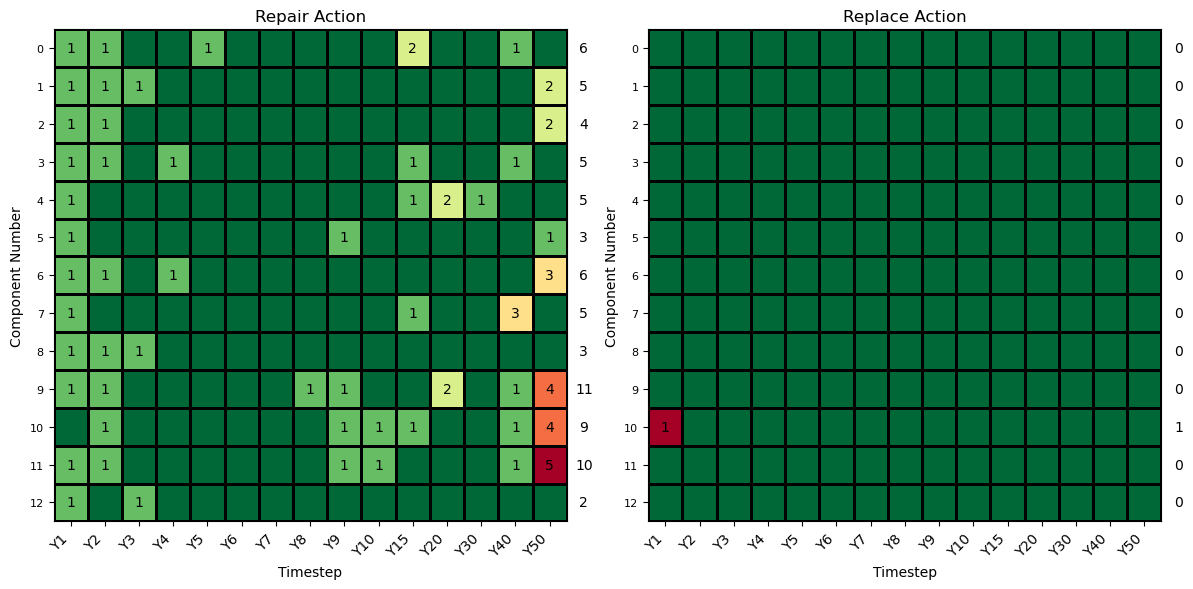

In [101]:
plot_cumulative_actions(cumulative_actions_reformatted)

## 5. Failure Analysis for Multiple Quay Walls

### 5.1. Define Additional Helper Functions and Constants

In [102]:
def read_scoring_table(file_path):
    """
    Reads the scoring table CSV file into a DataFrame.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: DataFrame containing the scoring table.
    """
    return pd.read_csv(file_path)


def analyze_quaywall_failures(file_path, plot_flag=None, ax=None, title=None):
    """
    Analyzes quay wall failures by processing the scoring table and extracting component states,
    counting failures, calculating cumulative actions over time, and optionally plotting the results.

    Args:
        file_path (str): Path to the CSV file containing the scoring table.
        plot_flag (str or None): Specifies the type of plot to generate. 
                                 Options: "failures", "actions", or None (default is None).
        ax (matplotlib.axes.Axes): The axes on which to plot the results (used if plot_flag is "failures" or "actions").
        title (str): Title for the plot (used if plot_flag is "failures" or "actions").

    Returns:
        tuple: 
            - failures_df (pd.DataFrame): DataFrame containing the failure counts per component.
            - final_df (pd.DataFrame): DataFrame containing the cumulative actions per component across timesteps.
            - total_failures (float): Total failures (sum of failures across components).
            - total_actions (float): Total actions (sum of actions across all components for Y50).
            - total_repair_actions (float): Total repair actions (sum of repair actions for Y50).
            - total_replace_actions (float): Total replace actions (sum of replace actions for Y50).
    """
    # Load the scoring table into a DataFrame
    df = read_scoring_table(file_path)

    # Extract the component states and action columns from the scoring table
    component_states, action_columns = extract_component_states(df)

    # Create a DataFrame that stores the component states and actions at each timestep
    output_df = create_timestep_df(df, component_states, action_columns, action_map)

    # Count the number of failures for each component over the entire period
    failures_df = count_failures_per_component(output_df)

    # Calculate the cumulative actions (repairs/replacements) over time for each component
    cumulative_actions_df = calculate_cumulative_actions(output_df)

    # Reformat the cumulative actions DataFrame for better readability
    final_df = reformat_cumulative_actions(cumulative_actions_df)

    # Calculate total failures (sum of 'Failure Count')
    total_failures = failures_df['Failure Count'].sum()

    # Calculate total actions (sum of Y50 across all components)
    total_actions = final_df.sum()['Y50']

    # Calculate total repair and replace actions (sum of Y50 for each action type)
    total_repair_actions = final_df[final_df['Action Type'] == 'Repair'].sum()['Y50']
    total_replace_actions = final_df[final_df['Action Type'] == 'Replace'].sum()['Y50']

    # Plotting logic based on plot_flag
    if plot_flag == "failures" and ax is not None and title is not None:
        # Plot failures by component type
        plot_total_failures_by_component_type(ax, failures_df, title)
    elif plot_flag == "actions" and ax is not None and title is not None:
        # If only one axis is provided, duplicate it for both repair and replace
        if not isinstance(ax, (list, np.ndarray)):
            ax = [ax, ax]
        # Plot cumulative actions
        plot_multiple_cumulative_actions(final_df, ax, title)

    return failures_df, final_df, total_failures, total_actions, total_repair_actions, total_replace_actions


def process_multiple_files(file_paths):
    """
    Processes multiple quay wall scoring files, aggregates the failures and actions across files, 
    computes total failures, total actions, total repair and replace actions for each file, 
    and saves the cumulative results to CSV files.

    Args:
        file_paths (list of str): List of file paths to the CSV files containing scoring data.

    Returns:
        tuple:
            - total_failures_df (pd.DataFrame): Cumulative DataFrame of failure counts.
            - total_final_df (pd.DataFrame): Cumulative DataFrame of actions per component across timesteps.
            - total_failures_list (list): List of total failures per file.
            - total_actions (list): List of total actions per quay wall.
            - total_repair_actions (list): List of total repair actions per quay wall.
            - total_replace_actions (list): List of total replace actions per quay wall.
    """
    # Initialize variables to store cumulative data
    total_failures_df = None
    total_final_df = None

    # Lists to store total computed values for each file
    total_failures_list = []
    total_actions = []
    total_repair_actions = []
    total_replace_actions = []

    # Iterate over each file path and process the file
    for file_path in file_paths:
        # Analyze each file's failures and actions
        failures_df, final_df, total_failures, total_action, total_repair, total_replace = analyze_quaywall_failures(file_path)

        # Aggregate failure counts across files
        if total_failures_df is None:
            total_failures_df = failures_df
        else:
            total_failures_df['Failure Count'] += failures_df['Failure Count']

        # Aggregate cumulative actions (columns Y1-Y50) across files
        if total_final_df is None:
            total_final_df = final_df
        else:
            total_final_df[['Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Y10', 'Y15', 'Y20', 'Y30', 'Y40', 'Y50']] += \
                final_df[['Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Y10', 'Y15', 'Y20', 'Y30', 'Y40', 'Y50']]

        # Append computed totals to the respective lists
        total_failures_list.append(total_failures)
        total_actions.append(total_action)
        total_repair_actions.append(total_repair)
        total_replace_actions.append(total_replace)

    # Save aggregated results to CSV files
    total_failures_df.to_csv('total_failures.csv', index=False)
    total_final_df.to_csv('total_final.csv', index=False)

    return total_failures_df, total_final_df, total_failures_list, total_actions, total_repair_actions, total_replace_actions


def plot_total_failures_by_component_type(ax, failures_df, title):
    """
    Plots total failures over the entire timeframe for MO-DCMAC model by component type.

    Args:
        ax (matplotlib.axes.Axes): The subplot axis to plot on.
        failures_df (pd.DataFrame): DataFrame containing failure statistics for each component.
        title (str): Title for the subplot.
    """
    component_types = {
        'Poles': range(9),
        'Kesps': range(9, 12),
        'Floor': [12]
    }

    failures_per_component_type = {component_type: 0 for component_type in component_types}

    # Aggregate failures by component type
    for index, row in failures_df.iterrows():
        component_number = int(index)
        component_failures = row['Failure Count']
        for component_type, component_nums in component_types.items():
            if component_number in component_nums:
                failures_per_component_type[component_type] += component_failures
                break

    # Plot the failures per component type
    bars = ax.bar(failures_per_component_type.keys(), failures_per_component_type.values(),
                  color=['skyblue', 'lightgreen', 'salmon'])
    ax.set_xlabel('Component Type')
    ax.set_ylabel('Total Failures')
    ax.set_title(title)
    ax.set_ylim(0, max(failures_per_component_type.values()) + 0.5)  # Ensure y-axis starts at 0 and add padding

    # Add total number of failures on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom')


def plot_multiple_cumulative_actions(final_df, ax, title):
    """
    Plots cumulative actions (repair and replace) for each component-action pair on the given axes.

    Args:
        final_df (pd.DataFrame): DataFrame containing cumulative actions for each component-action pair.
        ax (list of matplotlib.axes.Axes): List containing two axes for plotting repair and replace actions.
        title (str): Title for the subplot.
    """
    repair_data = final_df[final_df['Action Type'] == 'Repair'].drop(columns=['Component Number', 'Action Type']).values
    replace_data = final_df[final_df['Action Type'] == 'Replace'].drop(columns=['Component Number', 'Action Type']).values

    # Plot repair data
    im = ax[0].pcolormesh(repair_data, cmap='RdYlGn_r', edgecolors='k', linewidth=2, vmin=repair_data.min(), vmax=repair_data.max())
    ax[0].set_title(f'{title} - Repair Action')
    ax[0].set_ylabel('Component Number')
    ax[0].invert_yaxis()

    # Add annotations for repair data
    for i in range(repair_data.shape[0]):
        for j in range(repair_data.shape[1]):
            if repair_data[i, j] > 0:
                ax[0].text(j + 0.5, i + 0.5, int(repair_data[i, j]), color='black', ha='center', va='center')

    # Plot replace data
    im = ax[1].pcolormesh(replace_data, cmap='RdYlGn_r', edgecolors='k', linewidth=2, vmin=replace_data.min(), vmax=replace_data.max())
    ax[1].set_title(f'{title} - Replace Action')
    ax[1].set_ylabel('Component Number')
    ax[1].invert_yaxis()

    # Add annotations for replace data
    for i in range(replace_data.shape[0]):
        for j in range(replace_data.shape[1]):
            if replace_data[i, j] > 0:
                ax[1].text(j + 0.5, i + 0.5, int(replace_data[i, j]), color='black', ha='center', va='center')

    for ax_ in ax:
        ax_.set_xticks(np.arange(len(final_df.columns[2:])) + 0.5)
        ax_.set_xticklabels(final_df.columns[2:], rotation=45, ha='right')
        ax_.set_xlabel('Timestep')


def plot_multiple_quaywall_data(file_paths, titles, plot_flag, n_cols=3, figsize=(15, 20)):
    """
    Plots quay wall data based on the provided plot flag.

    Args:
        file_paths (list of str): List of file paths to the scoring table files.
        titles (list of str): List of titles for each subplot.
        plot_flag (str): The type of plot to generate ("failures" or "actions").
        n_cols (int): Number of columns for subplots (default is 3).
        figsize (tuple): Size of the entire figure (default is (15, 20)).
    
    Returns:
        None
    """
    # Determine the number of rows needed based on the number of file paths and columns
    if plot_flag == 'failures':
        n_rows = (len(file_paths) + n_cols - 1) // n_cols
        fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
    elif plot_flag == 'actions':
        fig, axs = plt.subplots(len(file_paths), 2, figsize=(15, 5 * len(file_paths)))

    # Flatten the axs only if it is a 2D array
    if plot_flag == 'failures':
        axs = axs.flatten()

    # Iterate over each file and plot the corresponding data
    for i, (file_path, title) in enumerate(zip(file_paths, titles)):
        analyze_quaywall_failures(file_path, plot_flag=plot_flag, ax=axs[i], title=title)

    plt.tight_layout()
    plt.show()


def add_bar_labels(bars, data, fmt='{:.0f}', position='right'):
    """
    Adds labels to bars on a bar chart.

    Args:
        bars (BarContainer): The bar container object from a matplotlib bar chart.
        data (list or tuple): The data values corresponding to each bar.
        fmt (str): The string format for the labels (default is '{:.0f}' for integers).
        position (str): Position of the labels ('right' for horizontal bars, 'top' for vertical).
    
    Returns:
        None
    """
    for bar, value in zip(bars, data):
        if position == 'right':  # Horizontal bars
            plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, fmt.format(value), va='center')
        elif position == 'top':  # Vertical bars
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), fmt.format(value), ha='center', va='bottom')


def plot_total_failures_comparison(titles, total_failures_list):
    """
    Plots a horizontal bar chart to compare total failures across quay walls.

    Args:
        titles (list): List of quay wall names or titles.
        total_failures_list (list): List of total failures corresponding to each quay wall.
    
    Returns:
        None
    """
    # Sort total failures and titles in descending order
    total_failures_list_sorted, titles_sorted = zip(*sorted(zip(total_failures_list, titles)))

    # Create a horizontal bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.barh(titles_sorted, total_failures_list_sorted, color='skyblue')
    plt.ylabel('Quay Wall')
    plt.xlabel('Total Component Failures')
    plt.title('Total Failures Comparison Across Quay Walls')

    # Add labels to each bar
    add_bar_labels(bars, total_failures_list_sorted, fmt='{:.0f}', position='right')

    plt.tight_layout()
    plt.show()


def plot_total_actions_comparison(titles, total_actions):
    """
    Plots a horizontal bar chart to compare total actions across quay walls.

    Args:
        titles (list): List of quay wall names or titles.
        total_actions (list): List of total actions corresponding to each quay wall.
    
    Returns:
        None
    """
    # Zip and sort total actions with titles in descending order
    total_actions_with_indices_sorted = sorted(zip(titles, total_actions), key=lambda x: x[1])

    # Unzip sorted data
    titles_sorted, total_actions_sorted = zip(*total_actions_with_indices_sorted)

    # Create a horizontal bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.barh(titles_sorted, total_actions_sorted, color='skyblue')
    plt.ylabel('Quay Wall')
    plt.xlabel('Total Number of Actions')
    plt.title('Total Actions Comparison Across Quay Walls')

    # Add total number of actions on top of each bar
    add_bar_labels(bars, total_actions_sorted, fmt='{:.0f}', position='right')

    plt.tight_layout()
    plt.show()


def plot_repair_replace_comparison(titles, total_repair_actions, total_replace_actions):
    """
    Plots a stacked bar chart to compare total repair and replace actions across quay walls.

    Args:
        titles (list): List of quay wall names.
        total_repair_actions (list): List of total repair actions corresponding to each quay wall.
        total_replace_actions (list): List of total replace actions corresponding to each quay wall.
    
    Returns:
        None
    """
    # Create a stacked bar chart
    plt.figure(figsize=(10, 6))
    index = range(len(titles))

    # Plot stacked bars for repair and replace actions
    bars1 = plt.bar(index, total_repair_actions, color='skyblue', label='Repair')
    bars2 = plt.bar(index, total_replace_actions, color='lightgreen', label='Replace', bottom=total_repair_actions)

    plt.xlabel('Quay Wall')
    plt.ylabel('Total Actions')
    plt.title('Total Actions Comparison Across Quay Walls')
    plt.xticks(index, titles, rotation=45, ha='right')  # Display quay wall names with a slight tilt for readability
    plt.legend()

    # Add total number of actions on top of each stacked bar
    for bars in [bars1, bars2]:
        add_bar_labels(bars, [bar.get_height() for bar in bars], fmt='{:.0f}', position='top')

    plt.tight_layout()
    plt.show()

In [103]:
file_paths = [
    '../../MODCMAC/results/LEG0301-A/MO_DCMAC_scoring.csv',
    '../../MODCMAC/results/LEG0301-B/MO_DCMAC_scoring.csv',
    '../../MODCMAC/results/LEG0301-C/MO_DCMAC_scoring.csv',
    '../../MODCMAC/results/OVW0401-A/MO_DCMAC_scoring.csv',
    '../../MODCMAC/results/OVW0401-B/MO_DCMAC_scoring.csv',
    '../../MODCMAC/results/OVW0401-D/MO_DCMAC_scoring.csv',
    '../../MODCMAC/results/OVW0402-A/MO_DCMAC_scoring.csv',
    '../../MODCMAC/results/PRG1001-A/MO_DCMAC_scoring.csv',
    '../../MODCMAC/results/PRG1001-B/MO_DCMAC_scoring.csv',
    '../../MODCMAC/results/PRG1001-C/MO_DCMAC_scoring.csv',
    '../../MODCMAC/results/PRG1001-D/MO_DCMAC_scoring.csv',
]

titles = ['LEG0301-A',
         'LEG0301-B',
         'LEG0301-C',
         'OVW0401-A',
         'OVW0401-B',
         'OVW0401-D',
         'OVW0402-A',
         'PRG1001-A',
         'PRG1001-B',
         'PRG1001-C',
         'PRG1001-D']

### 5.2. Calculate Total Combined Failures and Actions for each Component

In [104]:
# Calculate the required metrics for each quay wall
combined_failures, combined_df, failures_list, actions, repair_actions, replace_actions = process_multiple_files(file_paths)

# Show the Combined Failures DataFrame for inspection
print("Combined Failures: ")
display(combined_failures)

Combined Failures: 


,Component Number,Failure Count,Average Failures per Timestep,Failures within First 7 Timesteps
0,0,1,0.0,0
1,1,0,0.0,0
2,2,0,0.0,0
3,3,0,0.0,0
4,4,1,0.0,0
5,5,0,0.0,0
6,6,0,0.0,0
7,7,2,0.0,0
8,8,0,0.0,0
9,9,1,0.0,0


In [105]:
# Show the Combined Actions DataFrame for inspection
print("Combined Actions per Component: ")
display(combined_df)

Combined Actions per Component: 


,Component Number,Action Type,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10,Y15,Y20,Y30,Y40,Y50
0,0,Replace,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,Repair,11,11,0,0,7,4,1,1,0,0,0,1,5,7,2
2,1,Replace,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,Repair,11,11,11,2,1,0,0,0,1,1,0,0,5,5,7
4,2,Replace,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2,Repair,11,10,0,0,0,0,0,0,0,0,0,0,3,3,6
6,3,Replace,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,3,Repair,11,11,0,10,1,1,0,0,0,0,0,0,4,1,4
8,4,Replace,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,4,Repair,11,0,0,0,2,1,2,1,0,0,0,2,8,9,4


### 5.3. Plots

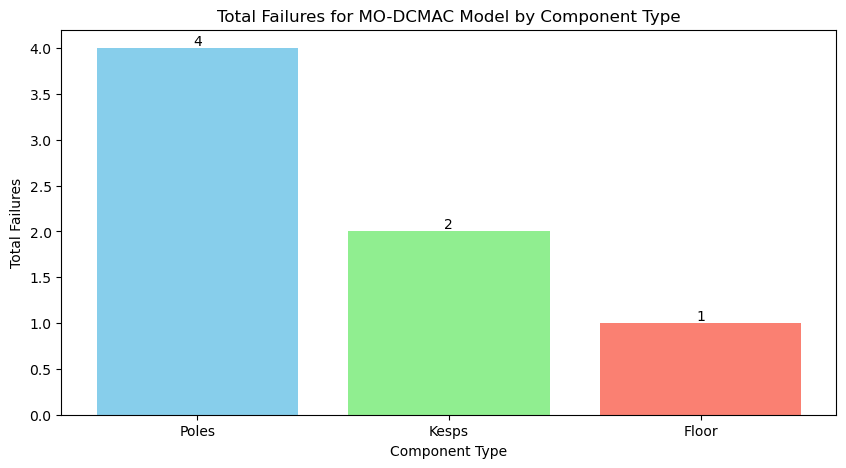

In [106]:
plot_failures_by_component_type(combined_failures)

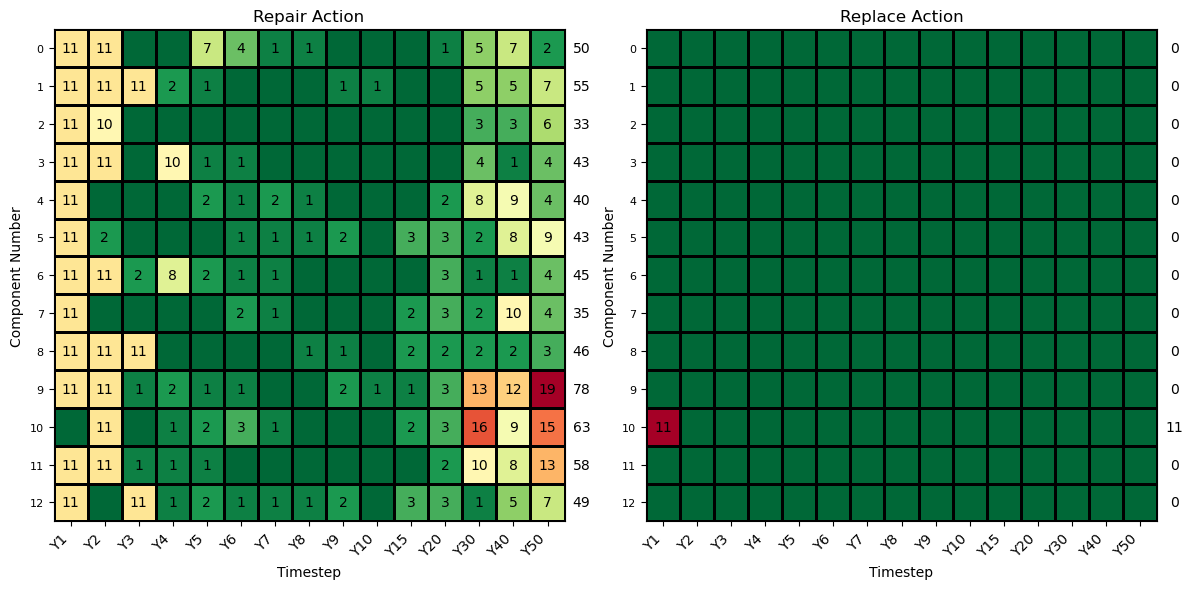

In [107]:
plot_cumulative_actions(combined_df)

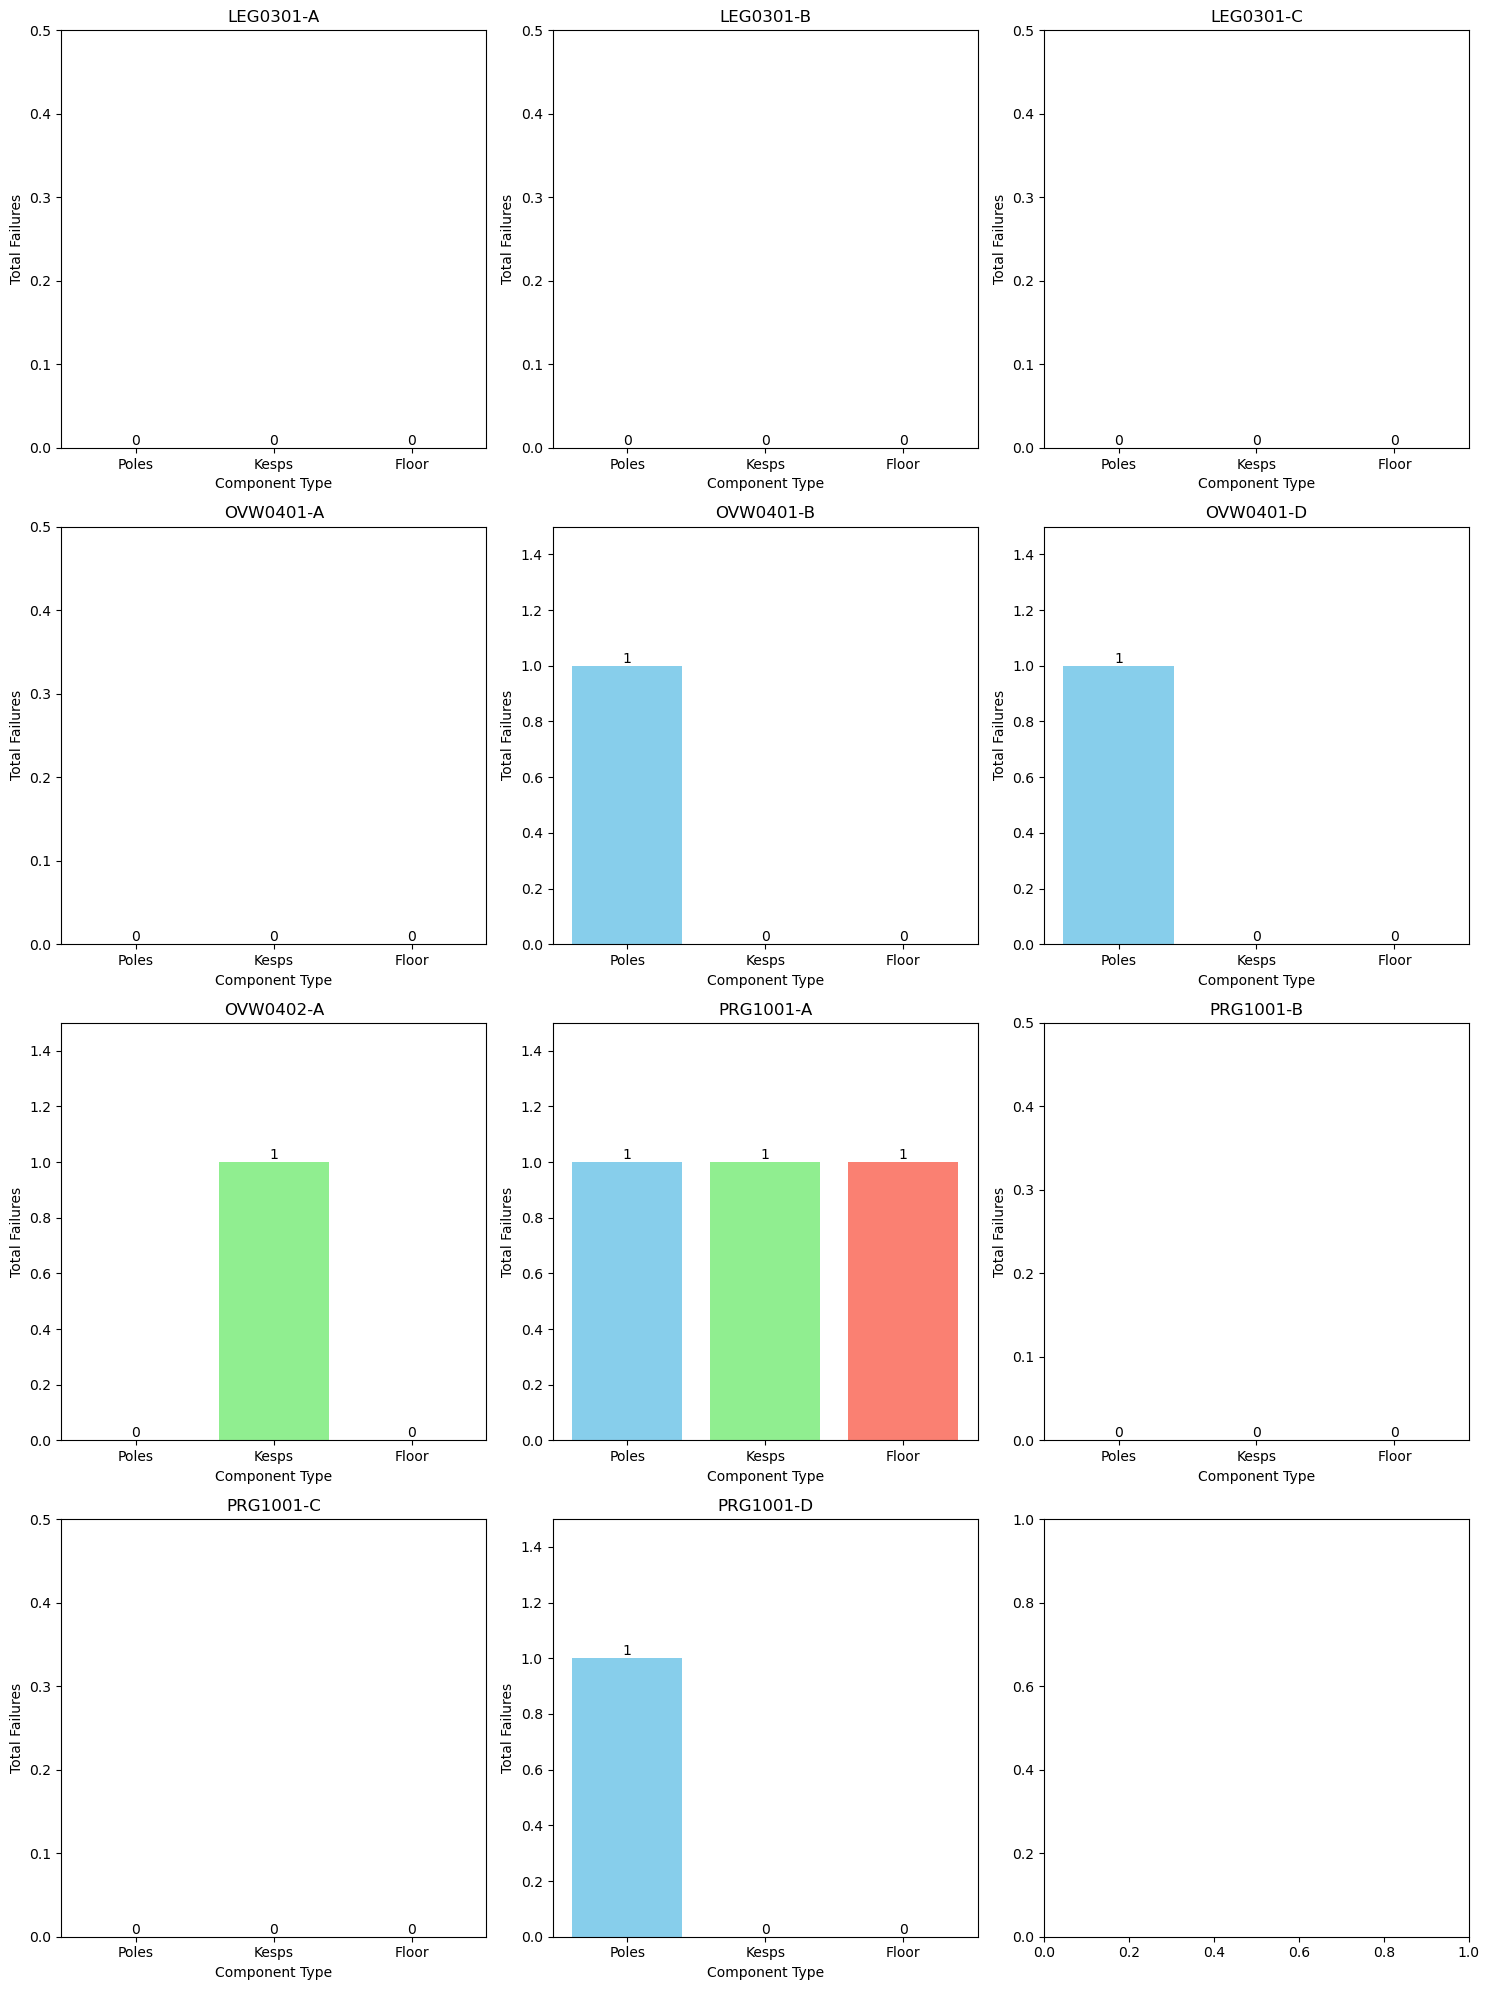

In [108]:
plot_multiple_quaywall_data(file_paths, titles, plot_flag="failures", n_cols=3, figsize=(15, 20))

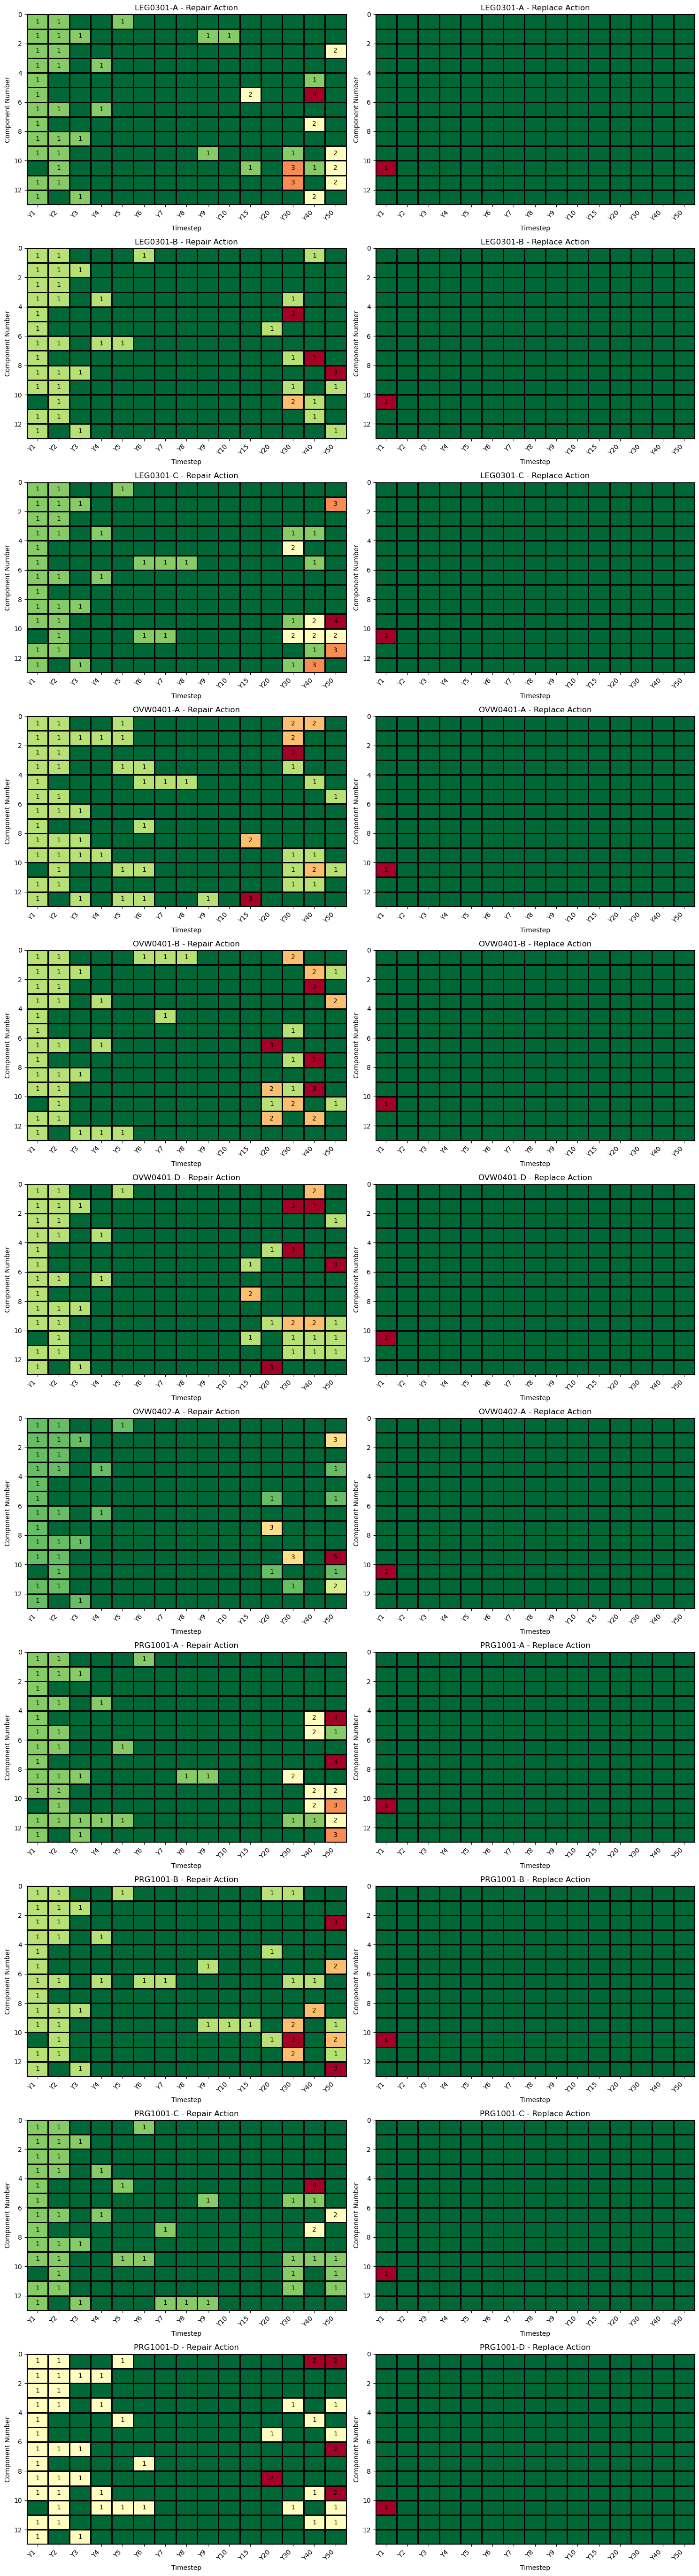

In [109]:
plot_multiple_quaywall_data(file_paths, titles, plot_flag="actions", n_cols=2, figsize=(15, 5 * len(file_paths)))

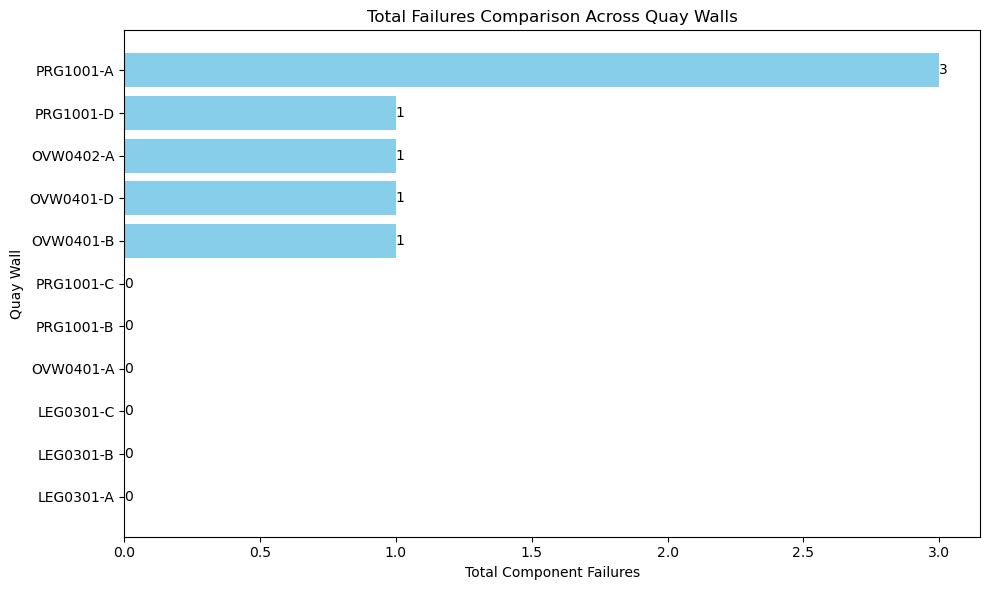

In [110]:
plot_total_failures_comparison(titles, failures_list)

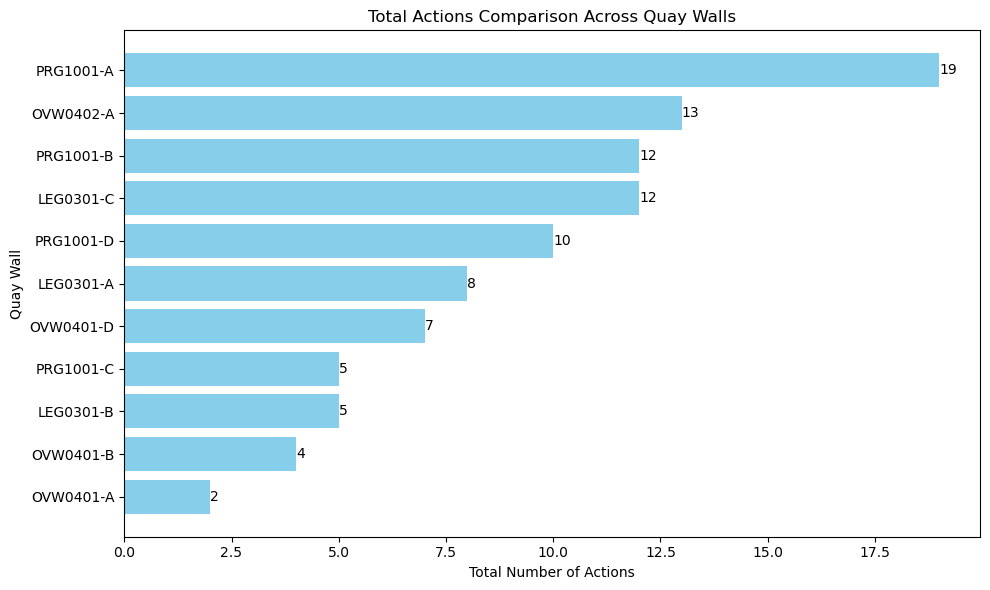

In [111]:
plot_total_actions_comparison(titles, actions)

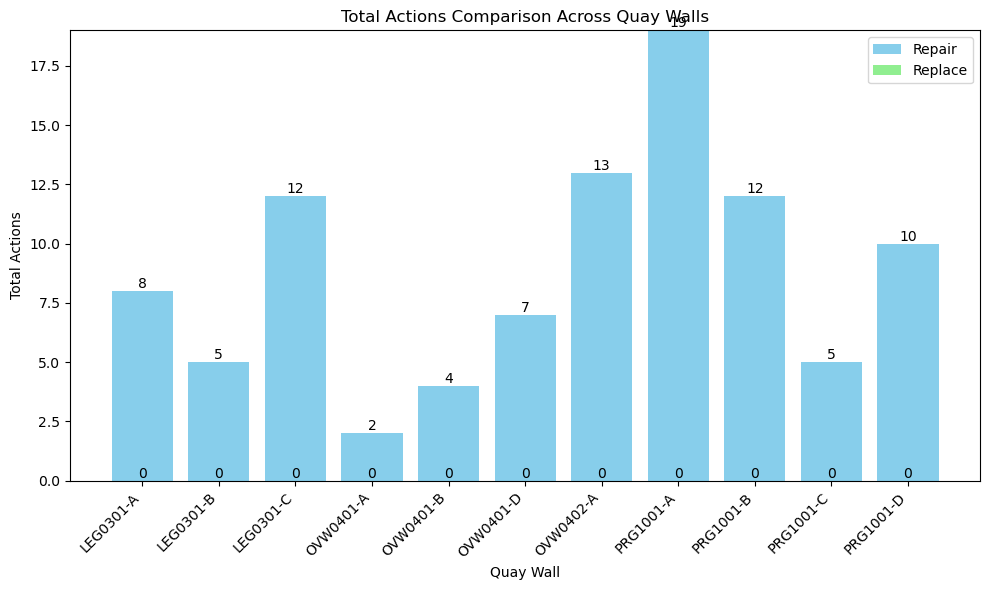

In [112]:
plot_repair_replace_comparison(titles, repair_actions, replace_actions)